In [1]:
!pip install jovian --upgrade --quiet

In [2]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

<IPython.core.display.Javascript object>

In [3]:
# Download dataset
dataset = EMNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True, split='letters')


Extracting data/EMNIST/raw/emnist.zip to data/EMNIST/raw
Processing byclass


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [4]:
# Other constants
input_size = 28*28
num_classes = len(dataset.classes)
len(dataset.classes)

26

In [5]:
len(dataset)

124800

In [6]:
img_tensor, label = dataset[0]
print(img_tensor, label)
print(img_tensor.shape, label)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0784, 0.4471, 0.4902, 0.3216, 0.1451, 0.1451,
          0.1529, 0.4510, 0.6157, 0.3686, 0.0824, 0.0392, 0.1255, 0.1451,
          0.1451, 0.1451, 0.1451, 0.1451, 0.1451, 0.1451,

In [7]:
batch_size = 128

In [8]:
# Training validation & test dataset
val_len = len(dataset)//10
train_ds, val_ds = random_split(dataset, [len(dataset) - val_len, val_len])
test_ds = EMNIST(root='data/', train=False, transform=transforms.ToTensor(), split='letters')

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size*2)
val_len

12480

Label: 18


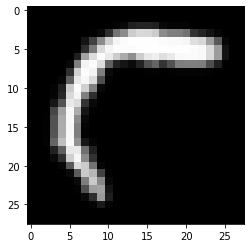

In [9]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [10]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, label = batch 
        labels = torch.tensor([x-1 for x in label])
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, label = batch 
        labels = torch.tensor([x-1 for x in label])
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [33]:
model = MnistModel()

In [34]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [35]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
evaluate(model, val_loader)

{'val_loss': 3.2674965858459473, 'val_acc': 0.04033800959587097}

In [37]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break

tensor([ 5, 25,  1, 14, 15, 22, 24, 10,  8, 13, 19, 10,  3, 12, 12,  2,  9, 24,
        10, 20, 16,  7,  5,  7, 26, 25,  2, 18,  4, 15,  7, 17, 13, 14, 20, 18,
         4, 12,  5,  3, 16, 15, 15,  4, 20, 12, 16,  7,  8, 23,  5, 25,  2,  1,
         6, 13, 22, 26, 17,  7,  5,  8, 13, 15, 26, 10,  9, 25,  1, 13, 17,  2,
         2,  4,  9,  3, 21, 13, 20, 23,  2,  1,  1,  1,  2,  3, 20, 26,  3,  8,
         2,  1, 10, 17,  6,  4, 19, 14, 16,  3, 18, 24, 24, 20, 25, 14,  8,  1,
        17, 16,  4, 16,  3, 14, 22,  3, 22,  2,  3, 24, 18, 21, 10,  2, 23,  8,
        19,  7])
torch.Size([128, 1, 28, 28])


In [38]:
history = fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1947, val_acc: 0.6601
Epoch [1], val_loss: 1.1281, val_acc: 0.6823
Epoch [2], val_loss: 1.0959, val_acc: 0.6914
Epoch [3], val_loss: 1.0806, val_acc: 0.6944
Epoch [4], val_loss: 1.0685, val_acc: 0.6991
Epoch [5], val_loss: 1.0637, val_acc: 0.6987
Epoch [6], val_loss: 1.0534, val_acc: 0.7042
Epoch [7], val_loss: 1.0538, val_acc: 0.7004
Epoch [8], val_loss: 1.0447, val_acc: 0.7062
Epoch [9], val_loss: 1.0401, val_acc: 0.7067


In [39]:
history += fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0371, val_acc: 0.7101
Epoch [1], val_loss: 1.0349, val_acc: 0.7117
Epoch [2], val_loss: 1.0333, val_acc: 0.7108
Epoch [3], val_loss: 1.0325, val_acc: 0.7122
Epoch [4], val_loss: 1.0311, val_acc: 0.7115


In [40]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0279, val_acc: 0.7132
Epoch [1], val_loss: 1.0277, val_acc: 0.7119
Epoch [2], val_loss: 1.0278, val_acc: 0.7127
Epoch [3], val_loss: 1.0279, val_acc: 0.7121
Epoch [4], val_loss: 1.0275, val_acc: 0.7134


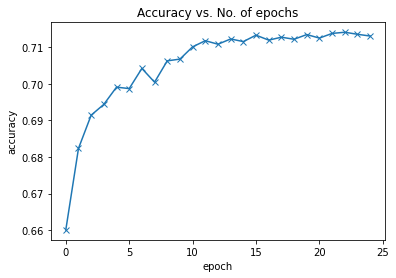

In [42]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [43]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 1.0193580389022827, 'val_acc': 0.7218464016914368}

In [44]:
jovian.log_metrics(test_acc=result['val_acc'], test_loss=result['val_loss'])

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········


[jovian] Error: The current API key is invalid or expired.


[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Metrics logged.


In [45]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 1 , Predicted: 5 Predicted Alphabet: e


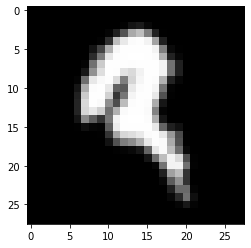

In [54]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label , ', Predicted:', predict_image(img, model) + 1, 'Predicted Alphabet:', dataset.classes[predict_image(img, model)])

Label: 1 , Predicted: 1 Predicted Alphabet: a


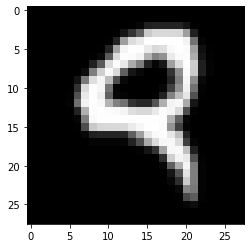

In [55]:
img, label = test_ds[35]
plt.imshow(img[0], cmap='gray')
print('Label:', label , ', Predicted:', predict_image(img, model) + 1, 'Predicted Alphabet:', dataset.classes[predict_image(img, model)])

Label: 1 , Predicted: 23 Predicted Alphabet: w


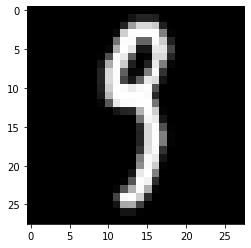

In [56]:
img, label = test_ds[300]
plt.imshow(img[0], cmap='gray')
print('Label:', label , ', Predicted:', predict_image(img, model) + 1, 'Predicted Alphabet:', dataset.classes[predict_image(img, model)])

Label: 11 , Predicted: 24 Predicted Alphabet: x


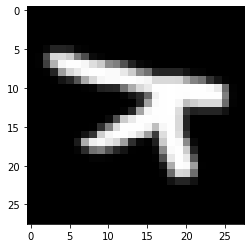

In [57]:
img, label = test_ds[8000]
plt.imshow(img[0], cmap='gray')
print('Label:', label , ', Predicted:', predict_image(img, model) + 1, 'Predicted Alphabet:', dataset.classes[predict_image(img, model)])

Label: 17 , Predicted: 1 Predicted Alphabet: a


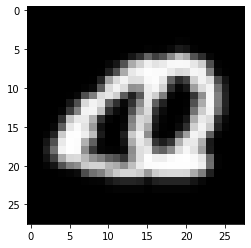

In [58]:
img, label = test_ds[12808]
plt.imshow(img[0], cmap='gray')
print('Label:', label , ', Predicted:', predict_image(img, model) + 1, 'Predicted Alphabet:', dataset.classes[predict_image(img, model)])

In [59]:
torch.save(model.state_dict(), 'logistic-regression-emnist.pth')

In [60]:
jovian.commit(project='logistic-regression-emnist', environment=None, outputs=['logistic-regression-emnist.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/twishabansal07/logistic-regression-emnist


<IPython.core.display.Javascript object>